### Data Exploration M5 Forecasting

This notebooks includes a exploratory data analysis of the M5 Forecasting dataset

* Visuallization of time series at different hirerchical levels
* Exploring price and calendar events
* Exploration of the sell price distributions

*Note: This notebook uses the datasets:
* walmartadd: https://www.kaggle.com/ulrich07/walmartadd
* m5forecasting: https://www.kaggle.com/c/m5-forecasting-uncertainty/data

In [2]:
import os
import gc
import time
import math
import datetime
from math import log, floor
from sklearn.neighbors import KDTree

import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.utils import shuffle
from tqdm.notebook import tqdm as tqdm
from scipy import stats                            # statistics
from datetime import datetime, date, timedelta     # time

import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import warnings
warnings.filterwarnings("ignore")

### Utilities

In [3]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df
#
def autocorrelation(ys, t=1):
    return np.corrcoef(ys[:-t], ys[t:])

### Load the dataset

In [4]:
INPUT_DIR = '../input/m5-forecasting-uncertainty'
INPUT_DIR2 = '../input/walmartadd'
#calendar = pd.read_csv(f'{INPUT_DIR}/calendar.csv')
#selling_prices = pd.read_csv(f'{INPUT_DIR}/sell_prices.csv')
#sample_submission = pd.read_csv(f'{INPUT_DIR}/sample_submission.csv')
sales = pd.read_csv(f'{INPUT_DIR2}/sales.csv')

In [5]:
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941,start,scale
0,HOBBIES_1_001_CA_1,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,3,3,0,1,901,0.773603
1,HOBBIES_1_002_CA_1,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,0,0,0,0,143,0.422049
2,HOBBIES_1_003_CA_1,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,0,0,0,2,3,0,1,1105,0.511990
3,HOBBIES_1_004_CA_1,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,4,0,1,3,0,2,6,36,1.778245
4,HOBBIES_1_005_CA_1,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,2,1,0,0,2,1,0,112,1.102354


In [6]:
series_cols = sales.columns[sales.columns.str.contains("d_")].values
level_cols = sales.columns[sales.columns.str.contains("d_")==False].values
days = np.arange(1, len(series_cols)+1)

In [7]:
timeseries = sales[series_cols].sum().values
len(timeseries)

1941

### Train/Test available dates

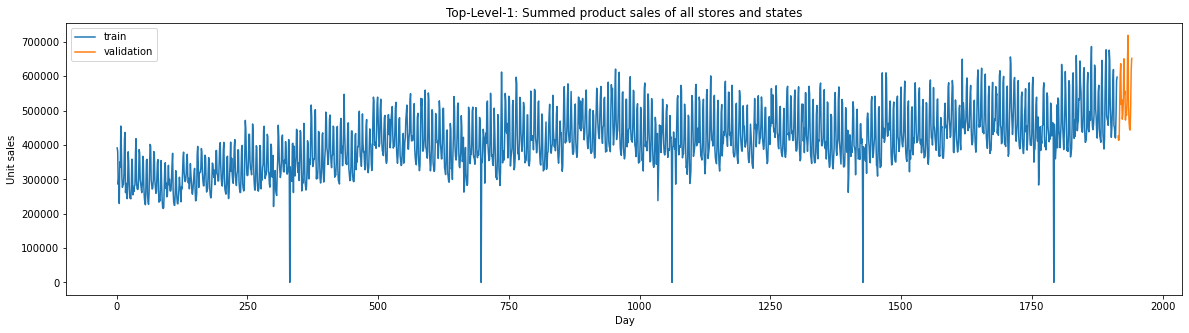

In [8]:
plt.figure(figsize=(20,5))
plt.plot(days[0:1913], timeseries[0:1913], label="train")
plt.plot(days[1914:], timeseries[1914:], label="validation")
plt.title("Top-Level-1: Summed product sales of all stores and states");
plt.legend()
plt.xlabel("Day")
plt.ylabel("Unit sales");

We take last 28 days as validation set. In the competition is requested forecast daily sales for the next 28 days and to make uncertainty estimates for these forecasts.

In [9]:
del timeseries

###  Visualization of Hirerarchical levels

The dataset hierarchy consits of 12 levels:

- 1 - The top is given by the **unit sales of all products**, aggregated for all stores/states.
- 2 - Unit sales of all products, aggregated for each **state**.
- 3 - Unit sales of all products, aggregated for each **store**.
- 4 - Unit sales of all products, aggregated for each **category**.
- 5 - Unit sales of all products, aggregated for each **department**.

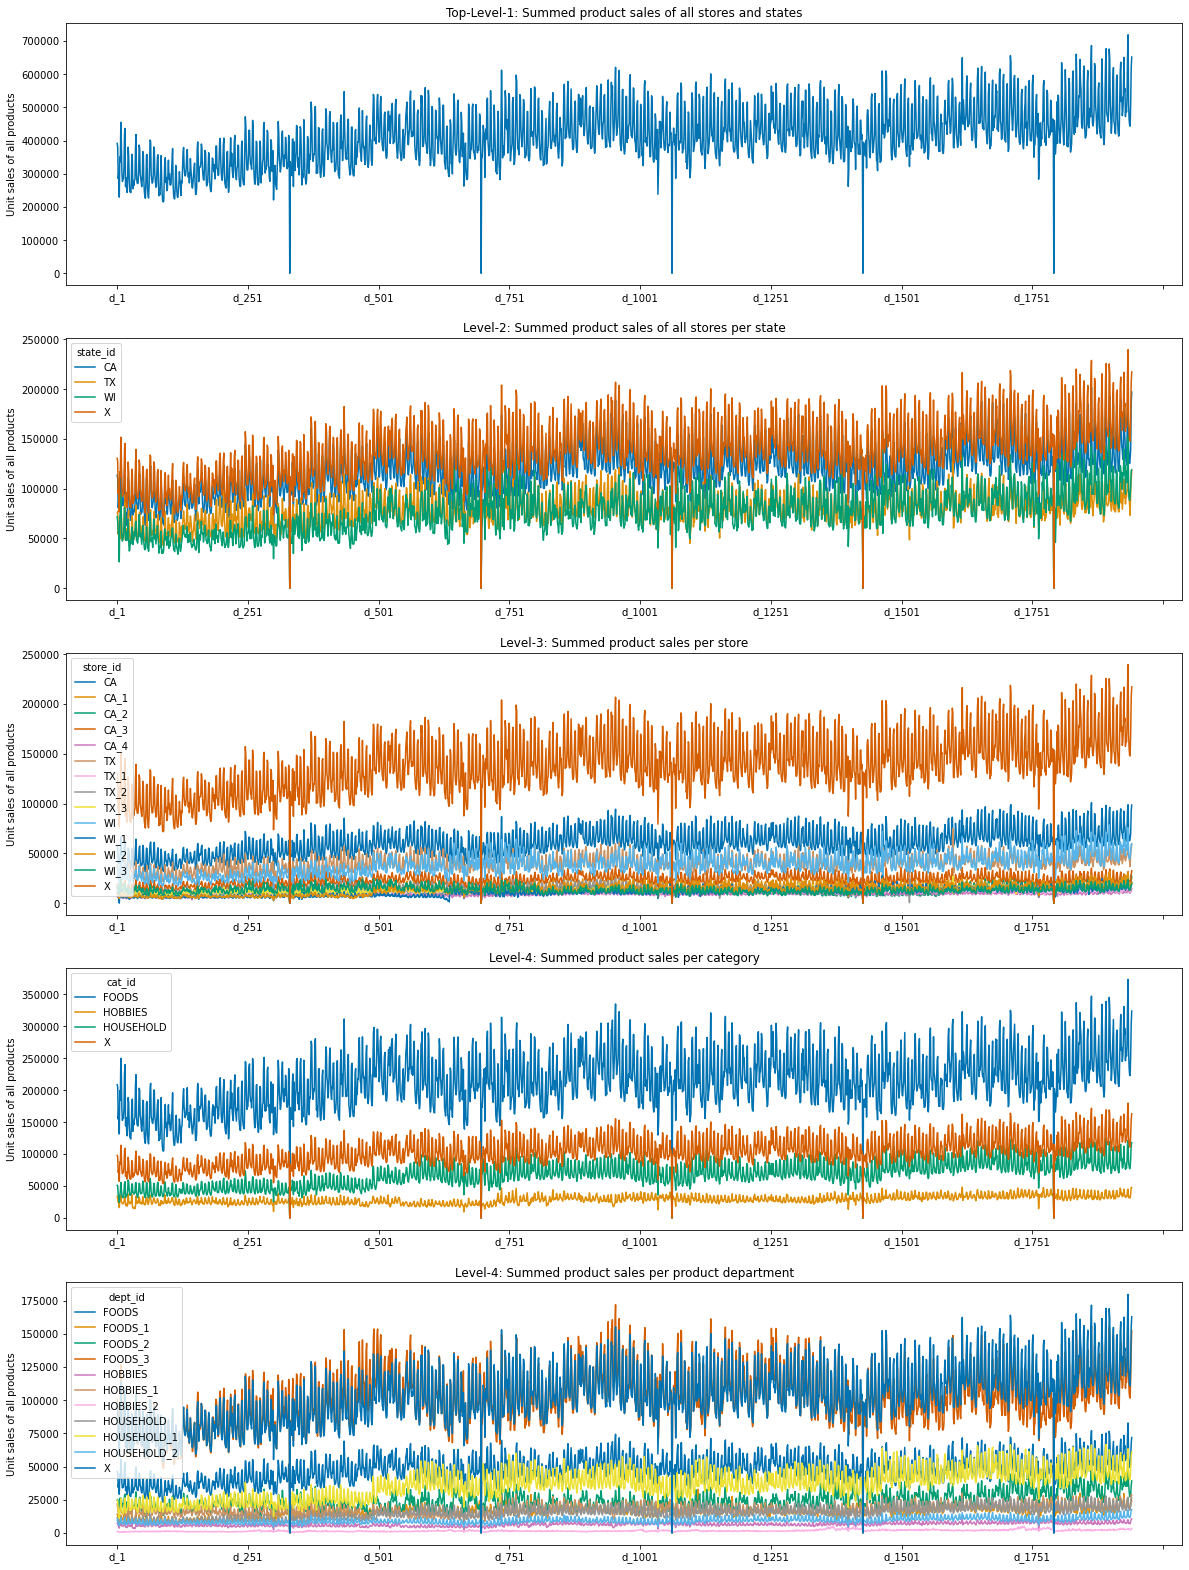

In [10]:
sns.set_palette("colorblind")

fig, ax = plt.subplots(5,1,figsize=(20,28))
sales[series_cols].sum().plot(ax=ax[0])
ax[0].set_title("Top-Level-1: Summed product sales of all stores and states")
ax[0].set_ylabel("Unit sales of all products");
sales.groupby("state_id")[series_cols].sum().transpose().plot(ax=ax[1])
ax[1].set_title("Level-2: Summed product sales of all stores per state");
ax[1].set_ylabel("Unit sales of all products");
sales.groupby("store_id")[series_cols].sum().transpose().plot(ax=ax[2])
ax[2].set_title("Level-3: Summed product sales per store")
ax[2].set_ylabel("Unit sales of all products");
sales.groupby("cat_id")[series_cols].sum().transpose().plot(ax=ax[3])
ax[3].set_title("Level-4: Summed product sales per category")
ax[3].set_ylabel("Unit sales of all products");
sales.groupby("dept_id")[series_cols].sum().transpose().plot(ax=ax[4])
ax[4].set_title("Level-4: Summed product sales per product department")
ax[4].set_ylabel("Unit sales of all products");


We can clearly see seasonality and trend patterns at all different levels of aggregations. It is important to notice also that there are some days without sales. 

In [11]:
del days

#### Reduce memory usage in this point

In [12]:
sales = reduce_mem_usage(sales, verbose = True)
#selling_prices = reduce_mem_usage(selling_prices, verbose = True)

Mem. usage decreased to 251.22 Mb (60.6% reduction)


### Exploring Price and Calendar Events

In [13]:
calendar = pd.read_csv(f'{INPUT_DIR}/calendar.csv')
calendar = reduce_mem_usage(calendar, verbose = True)

Mem. usage decreased to  0.12 Mb (41.9% reduction)


This section explores the additional datasets provided to us, i.e. calender and prices dataset. The prices dataset contains the information about the price of the products sold per store and date and the calender dataset contains information about the dates on which the products are sold

In [15]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [17]:
event1_bool = []   # boolean list. Captures whether an event exist or not
for i in range(0, len(calendar)):
    if calendar["event_name_1"].iloc[i] == calendar["event_name_1"].iloc[i]:
        event1_bool.append("True")
    else:
        event1_bool.append("False")
        
# inserting the above list in calendar_df
calendar.insert(loc = 9, column = "event_bool_1", value = event1_bool)

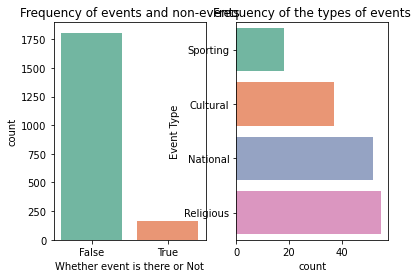

In [19]:
# plot distribution of event days
plt.subplot(1, 2, 1)
sns.countplot(calendar["event_bool_1"], palette = "Set2")
plt.title("Frequency of events and non-events")
plt.xlabel("Whether event is there or Not")

plt.subplot(1, 2, 2)
sns.countplot(y = calendar["event_type_1"], palette = "Set2")
plt.title("Frequency of the types of events")
plt.ylabel("Event Type")

plt.show()

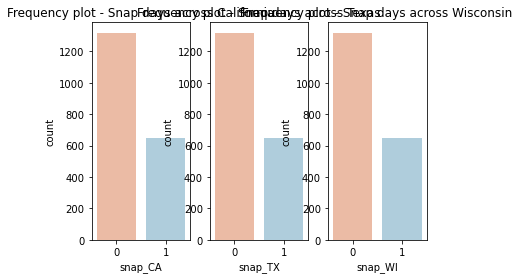

In [21]:
# plot distribution of snap days across three states
plt.subplot(1, 3, 1)
sns.countplot(x = calendar["snap_CA"], palette = "RdBu")
plt.title("Frequency plot - Snap days across California")

plt.subplot(1, 3, 2)
sns.countplot(x = calendar["snap_TX"], palette = "RdBu")
plt.title("Frequency plot - Snap days across Texas")

plt.subplot(1, 3, 3)
sns.countplot(x = calendar["snap_WI"], palette = "RdBu")
plt.title("Frequency plot - Snap days across Wisconsin")

plt.show()

**Insights**:

* There are total of 162 event days in the dataset, which forms 8.2% of the dataset
* The distribution of snap days is uniform in each state

### Exploration of the sell prices distributions

In [25]:
selling_prices = pd.read_csv(f'{INPUT_DIR}/sell_prices.csv')

In [27]:
selling_prices = reduce_mem_usage(selling_prices, verbose = True)

Mem. usage decreased to 130.48 Mb (37.5% reduction)


In [29]:
selling_prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.578125
1,CA_1,HOBBIES_1_001,11326,9.578125
2,CA_1,HOBBIES_1_001,11327,8.257812
3,CA_1,HOBBIES_1_001,11328,8.257812
4,CA_1,HOBBIES_1_001,11329,8.257812


In [33]:
# creating a few additional columns to aid in analysis below

selling_prices["state"] = selling_prices["store_id"].str[:2]
selling_prices["cat_id"] = selling_prices["item_id"].str[:-4]

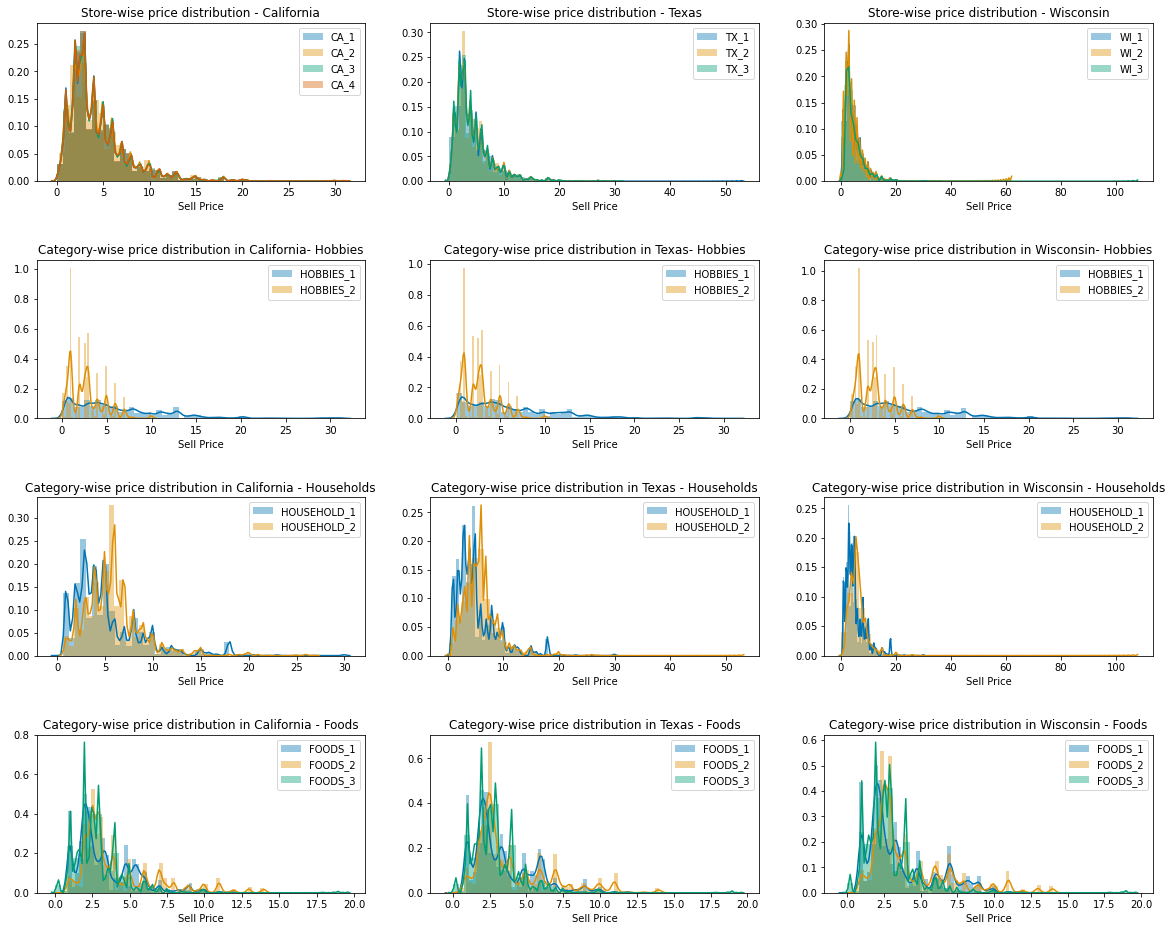

In [34]:
# plotting the distribution of various stores in a state

plt.figure(figsize = (20, 16))
plt.subplots_adjust(hspace = 0.5)

plt.subplot(4, 3, 1)
for i in ["CA_1", "CA_2", "CA_3", "CA_4"]:
    sns.distplot(selling_prices[selling_prices["store_id"] == i]["sell_price"], label = i)
    plt.legend()
    plt.xlabel("Sell Price")
    plt.title("Store-wise price distribution - California")

plt.subplot(4, 3, 2)
for j in ["TX_1", "TX_2", "TX_3"]:
    sns.distplot(selling_prices[selling_prices["store_id"] == j]["sell_price"], label = j)
    plt.legend()
    plt.xlabel("Sell Price")
    plt.title("Store-wise price distribution - Texas")

plt.subplot(4, 3, 3)
for k in ["WI_1", "WI_2", "WI_3"]:
    sns.distplot(selling_prices[selling_prices["store_id"] == k]["sell_price"], label = k)
    plt.legend()
    plt.xlabel("Sell Price")
    plt.title("Store-wise price distribution - Wisconsin")
    
plt.subplot(4, 3, 4)
for i in ["HOBBIES_1", "HOBBIES_2"]:
    sns.distplot(selling_prices[(selling_prices["cat_id"] == i) & (selling_prices["state"] == "CA")]["sell_price"], label = i)
    plt.legend()
    plt.xlabel("Sell Price")
    plt.title("Category-wise price distribution in California- Hobbies")
    
plt.subplot(4, 3, 5)
for i in ["HOBBIES_1", "HOBBIES_2"]:
    sns.distplot(selling_prices[(selling_prices["cat_id"] == i) & (selling_prices["state"] == "TX")]["sell_price"], label = i)
    plt.legend()
    plt.xlabel("Sell Price")
    plt.title("Category-wise price distribution in Texas- Hobbies")
    
plt.subplot(4, 3, 6)
for i in ["HOBBIES_1", "HOBBIES_2"]:
    sns.distplot(selling_prices[(selling_prices["cat_id"] == i) & (selling_prices["state"] == "WI")]["sell_price"], label = i)
    plt.legend()
    plt.xlabel("Sell Price")
    plt.title("Category-wise price distribution in Wisconsin- Hobbies")

plt.subplot(4, 3, 7)
for j in ["HOUSEHOLD_1", "HOUSEHOLD_2"]:
    sns.distplot(selling_prices[(selling_prices["cat_id"] == j) & (selling_prices["state"] == "CA")]["sell_price"], label = j)
    plt.legend()
    plt.xlabel("Sell Price")
    plt.title("Category-wise price distribution in California - Households")

plt.subplot(4, 3, 8)
for j in ["HOUSEHOLD_1", "HOUSEHOLD_2"]:
    sns.distplot(selling_prices[(selling_prices["cat_id"] == j) & (selling_prices["state"] == "TX")]["sell_price"], label = j)
    plt.legend()
    plt.xlabel("Sell Price")
    plt.title("Category-wise price distribution in Texas - Households")  
    
plt.subplot(4, 3, 9)
for j in ["HOUSEHOLD_1", "HOUSEHOLD_2"]:
    sns.distplot(selling_prices[(selling_prices["cat_id"] == j) & (selling_prices["state"] == "WI")]["sell_price"], label = j)
    plt.legend()
    plt.xlabel("Sell Price")
    plt.title("Category-wise price distribution in Wisconsin - Households")

plt.subplot(4, 3, 10)
for k in ["FOODS_1", "FOODS_2", "FOODS_3"]:
    sns.distplot(selling_prices[(selling_prices["cat_id"] == k) & (selling_prices["state"] == "CA")]["sell_price"], label = k)
    plt.legend()
    plt.xlabel("Sell Price")
    plt.title("Category-wise price distribution in California - Foods")
    
plt.subplot(4, 3, 11)
for k in ["FOODS_1", "FOODS_2", "FOODS_3"]:
    sns.distplot(selling_prices[(selling_prices["cat_id"] == k) & (selling_prices["state"] == "TX")]["sell_price"], label = k)
    plt.legend()
    plt.xlabel("Sell Price")
    plt.title("Category-wise price distribution in Texas - Foods")
    
plt.subplot(4, 3, 12)
for k in ["FOODS_1", "FOODS_2", "FOODS_3"]:
    sns.distplot(selling_prices[(selling_prices["cat_id"] == k) & (selling_prices["state"] == "WI")]["sell_price"], label = k)
    plt.legend()
    plt.xlabel("Sell Price")
    plt.title("Category-wise price distribution in Wisconsin - Foods")

**Insights**:
1. The probability distribution of the sell_price is almost identical in all the three states. The difference being is tail of distribution is long in case of Wisconsin. This might be due to the retailing strategy of selling many unique items with relatively small quantities sold of each, usually in addition to selling fewer popular items in large quantities. This wired article is a good introduction to long tail phenomenon
2. The distribution of food prices have strikingly similar price distribution, with both range and peaks occuring at the same places. This might be due to the fact that food prices are generally similar across states and somewhat regulated.
3. The Households have largest variations in the prices. They might be the ones which are contributing to long tails in the PDFs of prices.